In [1]:
import re
import nltk
import textstat
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from collections import Counter
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import pymongo

nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to E:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to E:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
def connect_mongo(query={},host='localhost', port=27017, username=None, password=None, no_id=True):
    if username and password:
        mongo_uri = "mongodb://%s:%s@%s:%s/%s" % (username, password, host, port, db)
        client = pymongo.MongoClient(mongo_uri)
    else:
        client = pymongo.MongoClient(host, port)
    return client
    
client = connect_mongo()
collect = client.issues.first_issues
# db = collect.find({"resolver_commit_num":{"$gte": 0, "$lte": 2}}).sort("closed_at",pymongo.ASCENDING)

In [4]:
df = pd.DataFrame(list(collect.find()))

In [13]:
notc = set()
tmp_collect = client.issues.second_issues
for data in tmp_collect.find():
    notc.add(data["owner"]+"/"+data["name"]+"/"+data["resolver"])

In [14]:
otc_iss, notc_iss = df[~(df.owner+"/"+df.name+"/"+df.resolver).isin(notc)], df[(df.owner+"/"+df.name+"/"+df.resolver).isin(notc)]

In [15]:
len(otc_iss), len(notc_iss)

(13317, 1995)

In [16]:
metrics = [
    "len_title", "len_body", 
    "n_code_snips", "n_urls", "n_imgs", 
    "coleman_liau_index", 
    "flesch_reading_ease", "flesch_kincaid_grade", "automated_readability_index",     
]

In [17]:
otc_iss[metrics].describe()

,len_title,len_body,n_code_snips,n_urls,n_imgs,coleman_liau_index,flesch_reading_ease,flesch_kincaid_grade,automated_readability_index
count,13317.000000,13317.000000,13317.000000,13317.000000,13317.000000,13317.000000,13317.000000,13317.000000,13317.000000
mean,7.692348,101.846061,0.739956,1.462567,0.014267,16.381982,50.603349,9.616550,17.418030
std,3.274359,102.083391,1.279986,3.118475,0.397621,28.965225,74.732349,10.565717,27.314024
min,1.000000,0.000000,0.000000,0.000000,0.000000,-28.010000,-4550.100000,-15.700000,-6.900000
25%,5.000000,36.000000,0.000000,0.000000,0.000000,9.700000,44.300000,6.800000,10.300000
50%,7.000000,73.000000,0.000000,1.000000,0.000000,12.500000,57.870000,8.700000,13.400000
75%,10.000000,139.000000,1.000000,2.000000,0.000000,16.640000,68.360000,11.100000,17.900000
max,40.000000,2504.000000,18.000000,274.000000,43.000000,1925.410000,206.840000,650.600000,1609.300000


In [18]:
notc_iss[metrics].describe()

,len_title,len_body,n_code_snips,n_urls,n_imgs,coleman_liau_index,flesch_reading_ease,flesch_kincaid_grade,automated_readability_index
count,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000
mean,7.696742,106.936842,0.839098,1.378446,0.011028,14.932426,53.868862,9.105965,15.983759
std,3.220540,154.663241,1.496460,2.557981,0.117985,15.759458,45.624561,6.749573,15.782539
min,1.000000,0.000000,0.000000,0.000000,0.000000,-15.810000,-978.590000,-15.700000,-4.300000
25%,5.000000,37.000000,0.000000,0.000000,0.000000,9.605000,45.220000,6.600000,10.300000
50%,7.000000,77.000000,0.000000,1.000000,0.000000,12.330000,58.920000,8.400000,13.400000
75%,9.000000,146.000000,1.000000,2.000000,0.000000,16.545000,68.970000,10.900000,17.600000
max,34.000000,5610.000000,36.000000,61.000000,3.000000,291.300000,206.840000,150.000000,295.100000


In [21]:
for metric in metrics:
    print(f"{metric:30} {mannwhitneyu(otc_iss[metric], notc_iss[metric])}")

len_title                      MannwhitneyuResult(statistic=13227362.5, pvalue=0.3791923366160463)
len_body                       MannwhitneyuResult(statistic=12976360.5, pvalue=0.047534086155121356)
n_code_snips                   MannwhitneyuResult(statistic=12721061.5, pvalue=0.00021717613651689932)
n_urls                         MannwhitneyuResult(statistic=12905087.0, pvalue=0.015912164829105936)
n_imgs                         MannwhitneyuResult(statistic=13261466.5, pvalue=0.22446371946234078)
coleman_liau_index             MannwhitneyuResult(statistic=13038291.0, pvalue=0.09128639075692291)
flesch_reading_ease            MannwhitneyuResult(statistic=12859617.5, pvalue=0.010631909339544875)
flesch_kincaid_grade           MannwhitneyuResult(statistic=12766194.0, pvalue=0.002470942742107254)
automated_readability_index    MannwhitneyuResult(statistic=13109123.0, pvalue=0.17151506921136167)


In [22]:
list(map(
    lambda x: (x[0], x[1] / len(otc_iss)), 
    sorted(Counter(sum(otc_iss.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.17338739956446647),
 ('help wanted', 0.11398963730569948),
 ('bug', 0.11256288953968611),
 ('Bug', 0.08139971465044679),
 ('enhancement', 0.05331531125628895),
 ('Docs', 0.021175940527145755),
 ('accepted', 0.01997446872418713),
 ('feature-request', 0.01997446872418713),
 ('waffle:review', 0.019899376736502217),
 ('easy', 0.018772996921228503),
 ('Easy', 0.018772996921228503),
 ('Documentation', 0.01869790493354359),
 ('Effort Low', 0.01847262897048885),
 ('<Bug>', 0.016745513253735828),
 ('docs', 0.015994593376886686),
 ('type: bug', 0.015619133438462116),
 ('rule', 0.014868213561612977),
 ('Hacktoberfest', 0.014492753623188406),
 ('Good First Issue', 0.01419238567244875),
 ('up-for-grabs', 0.014042201697078921)]

In [23]:
list(map(
    lambda x: (x[0], x[1] / len(notc_iss)), 
    sorted(Counter(sum(notc_iss.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.24160401002506265),
 ('bug', 0.14987468671679197),
 ('help wanted', 0.10175438596491228),
 ('Bug', 0.09273182957393483),
 ('enhancement', 0.07017543859649122),
 ('Effort Low', 0.04110275689223058),
 ('accepted', 0.034085213032581455),
 ('Docs', 0.02857142857142857),
 ('feature-request', 0.028070175438596492),
 ('rule', 0.028070175438596492),
 ('Difficulty Novice', 0.022556390977443608),
 ('easy', 0.02155388471177945),
 ('Good First Issue', 0.02055137844611529),
 ('Easy', 0.02055137844611529),
 ('Documentation', 0.01804511278195489),
 ('up-for-grabs', 0.017543859649122806),
 ('docs', 0.017042606516290727),
 ('Needs Tests', 0.016541353383458645),
 ('in progress', 0.015538847117794486),
 ('type: bug', 0.015037593984962405)]

In [34]:
counter1 = Counter()
for cat in otc_iss.label_category:
    counter1.update(cat)
total = sum(counter1.values())
for k, v in counter1.items():
    counter1[k] = v / total
counter1

Counter({'bug': 0.25279357644697226,
         'feature': 0.05667447306791569,
         'test': 0.022415523586483774,
         'build': 0.012579458012713282,
         'doc': 0.08002676480428236,
         'coding': 0.01759785881565741,
         'enhance': 0.07594513215122115,
         'gfi': 0.3330210772833724,
         'medium': 0.020140515222482436,
         'major': 0.044764135162261624,
         'triaged': 0.07005687520910003,
         'untriaged': 0.013984610237537639})

In [35]:
counter2 = Counter()
for cat in notc_iss.label_category:
    counter2.update(cat)
total = sum(counter2.values())
for k, v in counter2.items():
    counter2[k] = v / total
counter2

Counter({'bug': 0.24370050395968323,
         'feature': 0.0503959683225342,
         'test': 0.020518358531317494,
         'build': 0.013678905687544997,
         'doc': 0.06623470122390208,
         'coding': 0.014758819294456443,
         'enhance': 0.08531317494600432,
         'gfi': 0.35241180705543557,
         'medium': 0.02087832973362131,
         'major': 0.047516198704103674,
         'triaged': 0.06803455723542116,
         'untriaged': 0.01655867530597552})

Text(0, 0.5, 'ratio')

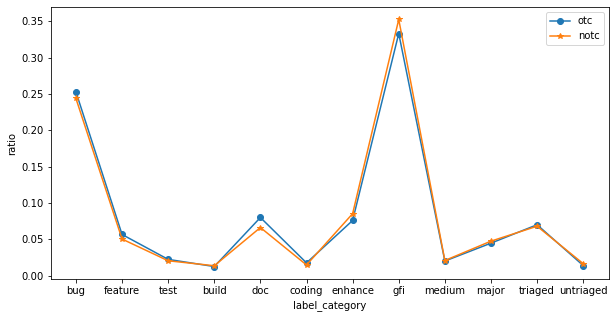

In [38]:
plt.figure(figsize=(10,5))
# x轴
x_counter = counter1.keys()
# 第一条折
y_counter1 = counter1.values()
y_counter2 = counter2.values()

plt.plot(x_counter, y_counter1, marker='o',label='otc')
plt.plot(x_counter, y_counter2, marker='*',label='notc')
plt.legend()  # 让图例生效
 
# 显示标签，如果不加这句，即使在plot中加了label='一些数字'的参数，最终还是不会显示标签
plt.legend(loc="upper right")
plt.xlabel('label_category')
plt.ylabel('ratio')

In [29]:
list(map(
    lambda x: (x[0], x[1] / len(otc_iss)), 
    sorted(Counter(sum(otc_iss.events, [])).items(), key=lambda x: -x[1])[0:20]
))

[('commented', 4.080874070736653),
 ('labeled', 2.566794323045731),
 ('subscribed', 2.3230457310205),
 ('mentioned', 1.8273635203123826),
 ('cross-referenced', 1.4870466321243523),
 ('referenced', 0.9565968311181197),
 ('unlabeled', 0.447172786663663),
 ('milestoned', 0.3343095291732372),
 ('assigned', 0.3008935946534505),
 ('renamed', 0.15506495456934746),
 ('demilestoned', 0.11023503792145378),
 ('unassigned', 0.07426597582037997),
 ('added_to_project', 0.07343996395584591),
 ('moved_columns_in_project', 0.058421566418863105),
 ('closed', 0.055192610948411804),
 ('reopened', 0.04835924006908463),
 ('removed_from_project', 0.014342569647818578),
 ('transferred', 0.005256439137943982),
 ('unsubscribed', 0.004280243298040099),
 ('comment_deleted', 0.004205151310355185)]

In [30]:
list(map(
    lambda x: (x[0], x[1] / len(notc_iss)), 
    sorted(Counter(sum(notc_iss.events, [])).items(), key=lambda x: -x[1])[0:20]
))

[('commented', 3.9889724310776944),
 ('labeled', 2.7984962406015037),
 ('subscribed', 2.275689223057644),
 ('mentioned', 1.8681704260651628),
 ('cross-referenced', 1.4030075187969926),
 ('referenced', 1.0867167919799499),
 ('milestoned', 0.44160401002506267),
 ('unlabeled', 0.4095238095238095),
 ('assigned', 0.30025062656641605),
 ('renamed', 0.18095238095238095),
 ('demilestoned', 0.17443609022556392),
 ('added_to_project', 0.11629072681704261),
 ('unassigned', 0.06766917293233082),
 ('moved_columns_in_project', 0.06466165413533835),
 ('closed', 0.05213032581453634),
 ('reopened', 0.0456140350877193),
 ('removed_from_project', 0.03208020050125313),
 ('unsubscribed', 0.011027568922305764),
 ('comment_deleted', 0.005513784461152882),
 ('connected', 0.005513784461152882)]

In [70]:
same1 = list(1 if otc_iss.loc[x].reporter_feat["name"] == otc_iss.loc[x].resolver else 0 for x in otc_iss.index)
same2 = list(1 if notc_iss.loc[x].reporter_feat["name"] == notc_iss.loc[x].resolver else 0 for x in notc_iss.index)

In [72]:
print(sum(same1)/len(same1),sum(same2)/len(same2))
print(mannwhitneyu(same1, same2))

0.36719981977922955 0.2962406015037594
MannwhitneyuResult(statistic=12341106.0, pvalue=3.516832657805272e-10)
